## Data split

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS 
from sklearn.model_selection import train_test_split

import pickle

import json 

from sqlalchemy import create_engine

### Run

In [2]:
id_vectorizer = "02"

In [3]:
id_model = "02"

### Import data

In [4]:
en = create_engine('mysql+mysqlconnector://duinmat:$Mo/qdGSnX$MEi@oege.ie.hva.nl/zduinmat')

In [5]:
df = pd.read_sql("Select * from Tweets_clean_with_Sentiment", en)

### Lower case

In [6]:
df.content= [content.lower() for content in df.content]

### Remove not helpful elements

In [7]:
for ch in ['0','1','2','3','4','5','6','7','8','9',',',"'",'\\','`','*','_','{','}','[',']','(',')','>','#','+','-','.','!','$','\'']:
        df.content = [content.replace(ch,'') for content in df.content]

### Add stop words

In [8]:
my_words = ["bitcoin","btc"]

my_stop_words = ENGLISH_STOP_WORDS.union(my_words)

### Tfldf

In [9]:
max_features= 2000
max_df=0.90
min_df=2
ngram_range=(1, 3)

In [10]:
vect = TfidfVectorizer(max_features=max_features,max_df=max_df , min_df=min_df,stop_words=my_stop_words,ngram_range=ngram_range).fit(df.content)
X = vect.transform(df.content)

In [ ]:
pickle.dump( vect, open( "Data/{}_data_vectorizer.p".format(id_vectorizer), "wb" ) )

In [11]:
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
X_df.head()

C:\Users\Trabajo\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,access,accuracy,activity,activity minute,activity minute vol,activity minutes,activity minutes vol,activity seconds,activity seconds vol,ada,...,yobit hitbtc livecoin,zar,zar free,zar luno,zar luno exchange,zcore,zcore stratum,zcore stratum fuckthebanks,zec,zrx
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.20959,0.0,0.0,0.0,0.0,0.237267,0.237281,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train/ test split

In [12]:
y = df.vaderSentiment_number
X = X_df

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Train model

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

# from xgboost import XGBClassifier
# from xgboost import plot_importance

### LogisticRegression

In [ ]:
log_reg = LogisticRegression(multi_class='multinomial',max_iter=1000)

In [ ]:
log_reg.fit(X_train,y_train)

In [ ]:
log_reg.score(X_train,y_train)

In [ ]:
log_reg.score(X_test,y_test)

In [ ]:
pickle.dump( log_reg, open( "Model/{}_LogisticRegression.p".format(id_model), "wb" ) )

### Get Model

In [ ]:
def get_model(model_id,estimator_name):
    return pickle.load( open("Model/{}_{}.p".format(model_id,estimator_name), "rb" ) )

### Get Confusion Matrix

In [ ]:
def get_confusion_matrix(y_test,y_predicted,estimator,id_model):
    cm = confusion_matrix(y_test, y_predicted)/len(y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot()
    plt.title(('Confusion matrix of the {} classifier').format(estimator.__class__.__name__))
    plt.savefig("Model/{}_{}_confusion_matrix.pdf".format(id_model,estimator.__class__.__name__))
    plt.show()

### Explore models results 

In [ ]:
log_reg = get_model("02","LogisticRegression")

In [ ]:
y_predicted = log_reg.predict(X_test)

In [ ]:
get_confusion_matrix(y_test,y_predicted,log_reg,id_model)

### Logistic Regression Hyperparameter Tuning

In [ ]:
search_space = {
    "C" : [10,5,1,0.1],
    "penalty" : ["l1","l2","elasticnet"],
    "solver" : ["newton-cg", "lbfgs", "liblinear"]
}

from sklearn.model_selection import GridSearchCV
# make a GridSearchCV object
GS = GridSearchCV(estimator = log_reg,
                  param_grid = search_space,
                  scoring = ["accuracy"], 
                  refit = "accuracy",
                  cv = 2,
                  verbose = 2)

GS.fit(X_train, y_train)

print(GS.best_estimator_) # to get the complete details of the best model
print(GS.best_params_) # to get only the best hyperparameter values that we searched for
print(GS.best_score_) # score according to the metric we passed in refit

df_gridsearch = pd.DataFrame(GS.cv_results_)
df_gridsearch[["mean_score_time","params","mean_test_accuracy"]].sort_values("mean_test_accuracy",ascending=False).head()


### Support Vector Machine

In [15]:
from sklearn import svm

svmach = svm.SVC(C=1.0, kernel='linear')
svmach.fit(X_train,y_train)
svmach.score(X_train,y_train)
svmach.score(X_test,y_test)

# ~40h (2400min)
pickle.dump( svmach, open( "Model2_svm.p", "wb" )) 


In [15]:
svmach = pickle.load(open("Model2_svm.p", 'rb'))

In [23]:
def get_model(model_id,estimator_name):
    return pickle.load( open("Model/{}_{}.p".format(model_id,estimator_name), "rb" ) )

def get_confusion_matrix(y_test,y_predicted,estimator,id_model):
    cm = confusion_matrix(y_test, y_predicted)/len(y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot()
    plt.title(('Confusion matrix of the {} classifier').format(estimator.__class__.__name__))
    plt.savefig("Model/{}_{}_confusion_matrix.pdf".format(id_model,estimator.__class__.__name__))
    plt.show()


### SVM performance

In [17]:
pickle.dump(svmach, open("Model1_svm.p", 'wb'))

In [ ]:
    y_predicted = svmach.predict(X_test)

    get_confusion_matrix(y_test,y_predicted,svmach,id_model)

In [16]:
y_predicted = svmach.predict(X_test)

In [17]:
# Accuracy
metrics.accuracy_score(y_test, y_predicted)

0.9146293361254743

In [ ]:
# F1 score
metrics.f1_score(y_test, y_predicted)

In [ ]:
# Area under ROC curve
metrics.roc_auc_score(y_test, y_predicted)

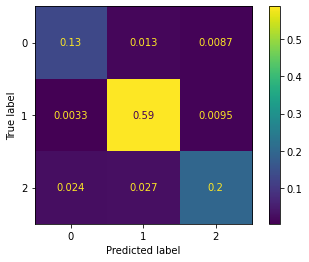

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_predicted)/len(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
